In [1]:
library(IRdisplay)
library(Cairo)

library(data.table)
library(arrow)
library(ggplot2)
library(cowplot)
library(ggrepel)
library(ggthemes)
library(ggpubr)
library(ggtext)
library(patchwork)
library(grid)
library(gridExtra)
library(scales)
library(stringr)
library(RColorBrewer)
library(yaml)
library(plyr)
# library(dplyr)
library(tidyverse)
library(ggnewscale)
library(png)
library(rstatix)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()      masks plyr::arrange()
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ dplyr::combine()      masks gr

In [2]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [3]:
# Set display size of plots
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res=200)

In [4]:
LINESIZE = 0.3
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

In [5]:
base_path <- '/data/nasif12/home_if12/tsi/training_results_v16/gtex_v8_old_dna/predict_folds/subset=all/plots/compare_results.py@dna_only_splice_sv_dups_Enformer_Aparent2_SpeciesLM'

In [6]:
# %%
superscript_mapping = c(
    `-` = '⁻',
    `+` = "", # ⁺
    `0` = "\u2070",
    `1` = "\u00B9",
    `2` = "\u00B2",
    `3` = "\u00B3",
    `4` = "\u2074",
    `5` = "\u2075",
    `6` = "\u2076",
    `7` = "\u2077",
    `8` = "\u2078",
    `9` = "\u2079"
)

In [7]:
fancy_scientific <- function(l, digits=NULL, low=1/1000, high=1000) {
    # turn in to character string in scientific notation
    l = as.numeric(l)
    if (is.na(l)) {
        return("NA")
    }
    if (l == 0) {
        return("0")
    }
    if ((low < l) & (l < high)){
        return(format(l, scientific=FALSE, digits=digits, big.mark=",", trim=TRUE))
    }
    l = format(l, scientific=TRUE, digits=digits)

    # l <- format(l, scientific = TRUE)
    # split into factor and exponent
    l_split = strsplit(l, 'e')[[1]]
    if (! is.null(digits)) {
        l_split[1] = round(as.numeric(l_split[1]), digits)
    }
    # make exponent superscript
    l_split[2] = as.numeric(l_split[2])
    l_split[2] = paste(
        lapply(strsplit(l_split[2], "")[[1]], function(x) noquote(superscript_mapping[[x]])),
        collapse=''
    )
    # concat everything
    l_split = paste0(l_split[1], "x10", l_split[2])

    l_split
}

In [8]:
all_lower = function(df, model_col, value_col, comp_x, comp_y){
    val_x = df[[value_col]][df[[model_col]] == comp_x]
    val_y = df[[value_col]][df[[model_col]] == comp_y]
    return(all(val_x < val_y))
}

In [9]:
selected_models = c(
    "LOFTEE+CADD+weighted csq.+disp.+AbSplice",
    # "LOFTEE+CADD+weighted csq.+disp.+AbSplice+SpeciesLM",
    # "LOFTEE+CADD+weighted csq.+disp.+AbSplice+near tss",
    "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer",
    "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2",
    "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2+SpeciesLM"
)
selected_models

[1] "LOFTEE+CADD+weighted csq.+disp.+AbSplice"                            
[2] "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer"                   
[3] "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2"          
[4] "LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2+SpeciesLM"

In [10]:
rename_models = list(
    `LOFTEE+CADD+weighted csq.+disp.+AbSplice` = 'AbExp',
    # `LOFTEE+CADD+weighted csq.+disp.+AbSplice+near tss` = 'AbExp + TSS',
    # `LOFTEE+CADD+weighted csq.+disp.+AbSplice+SpeciesLM` = 'AbExp\n+ SpeciesLM',
    `LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer` = '+ Enformer',
    `LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2` = '+ Aparent2',
    `LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2+SpeciesLM` = '+ SpeciesLM'
)

In [11]:
# sapply(comparisons, function(x) x[1] %in% rename_models & x[2] %in% rename_models )

In [12]:
# rename_models = as.list(selected_models)
# names(rename_models) = rename_models

In [13]:
rename_models

$`LOFTEE+CADD+weighted csq.+disp.+AbSplice`
[1] "AbExp"

$`LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer`
[1] "+ Enformer"

$`LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2`
[1] "+ Aparent2"

$`LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+Aparent2+SpeciesLM`
[1] "+ SpeciesLM"

In [14]:
prc_df = as.data.table(read_parquet(file.path(base_path, "/prc_df.parquet")))
prc_df = prc_df[`model` %in% selected_models]
model_idx = unique(prc_df[,.(`model`, `idx`)])[order(`idx`, decreasing = FALSE)]
prc_df$model <- factor(prc_df$model, levels=model_idx$model)
prc_df$model <- recode(prc_df$model, !!!rename_models)
prc_df

precision,recall,threshold,is_binary,auc,model,label,idx
<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>,<chr>,<int>
0.0000,0.0000,6.530971,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.2500,0.0001,6.479377,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.4000,0.0002,6.475304,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.5000,0.0003,6.448271,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.5000,0.0004,6.447859,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.4444,0.0004,6.323641,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.5000,0.0004,6.288099,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.5000,0.0005,6.116747,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0
0.5385,0.0006,6.103118,FALSE,0.06860093,AbExp,LOFTEE+CADD+weighted csq.+disp.+AbSplice (6.86% auPRC),0


In [15]:
tissue_performance = as.data.table(read_parquet(file.path(base_path, "/performance.tissue.parquet")))
tissue_performance = tissue_performance[`model` %in% selected_models]
model_idx = unique(tissue_performance[,.(`model`, `idx`)])[order(`idx`, decreasing = FALSE)]
tissue_performance$model <- factor(tissue_performance$model, levels=model_idx$model)
tissue_performance$model <- recode(tissue_performance$model, !!!rename_models)
tissue_performance

model,tissue,auc,idx,n_true,auc_mean,auc_median,auc_std
<fct>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
AbExp,Adipose Tissue,0.070079751,0,733,0.05527275,0.05833111,0.03276041
AbExp,Adrenal Gland,0.066544250,0,172,0.05527275,0.05833111,0.03276041
AbExp,Blood,0.037582248,0,591,0.05527275,0.05833111,0.03276041
AbExp,Blood Vessel,0.086945536,0,985,0.05527275,0.05833111,0.03276041
AbExp,Brain,0.073239027,0,1398,0.05527275,0.05833111,0.03276041
AbExp,Breast,0.043192488,0,205,0.05527275,0.05833111,0.03276041
AbExp,Colon,0.053932142,0,445,0.05527275,0.05833111,0.03276041
AbExp,Esophagus,0.077925204,0,1071,0.05527275,0.05833111,0.03276041
AbExp,Heart,0.105975515,0,522,0.05527275,0.05833111,0.03276041


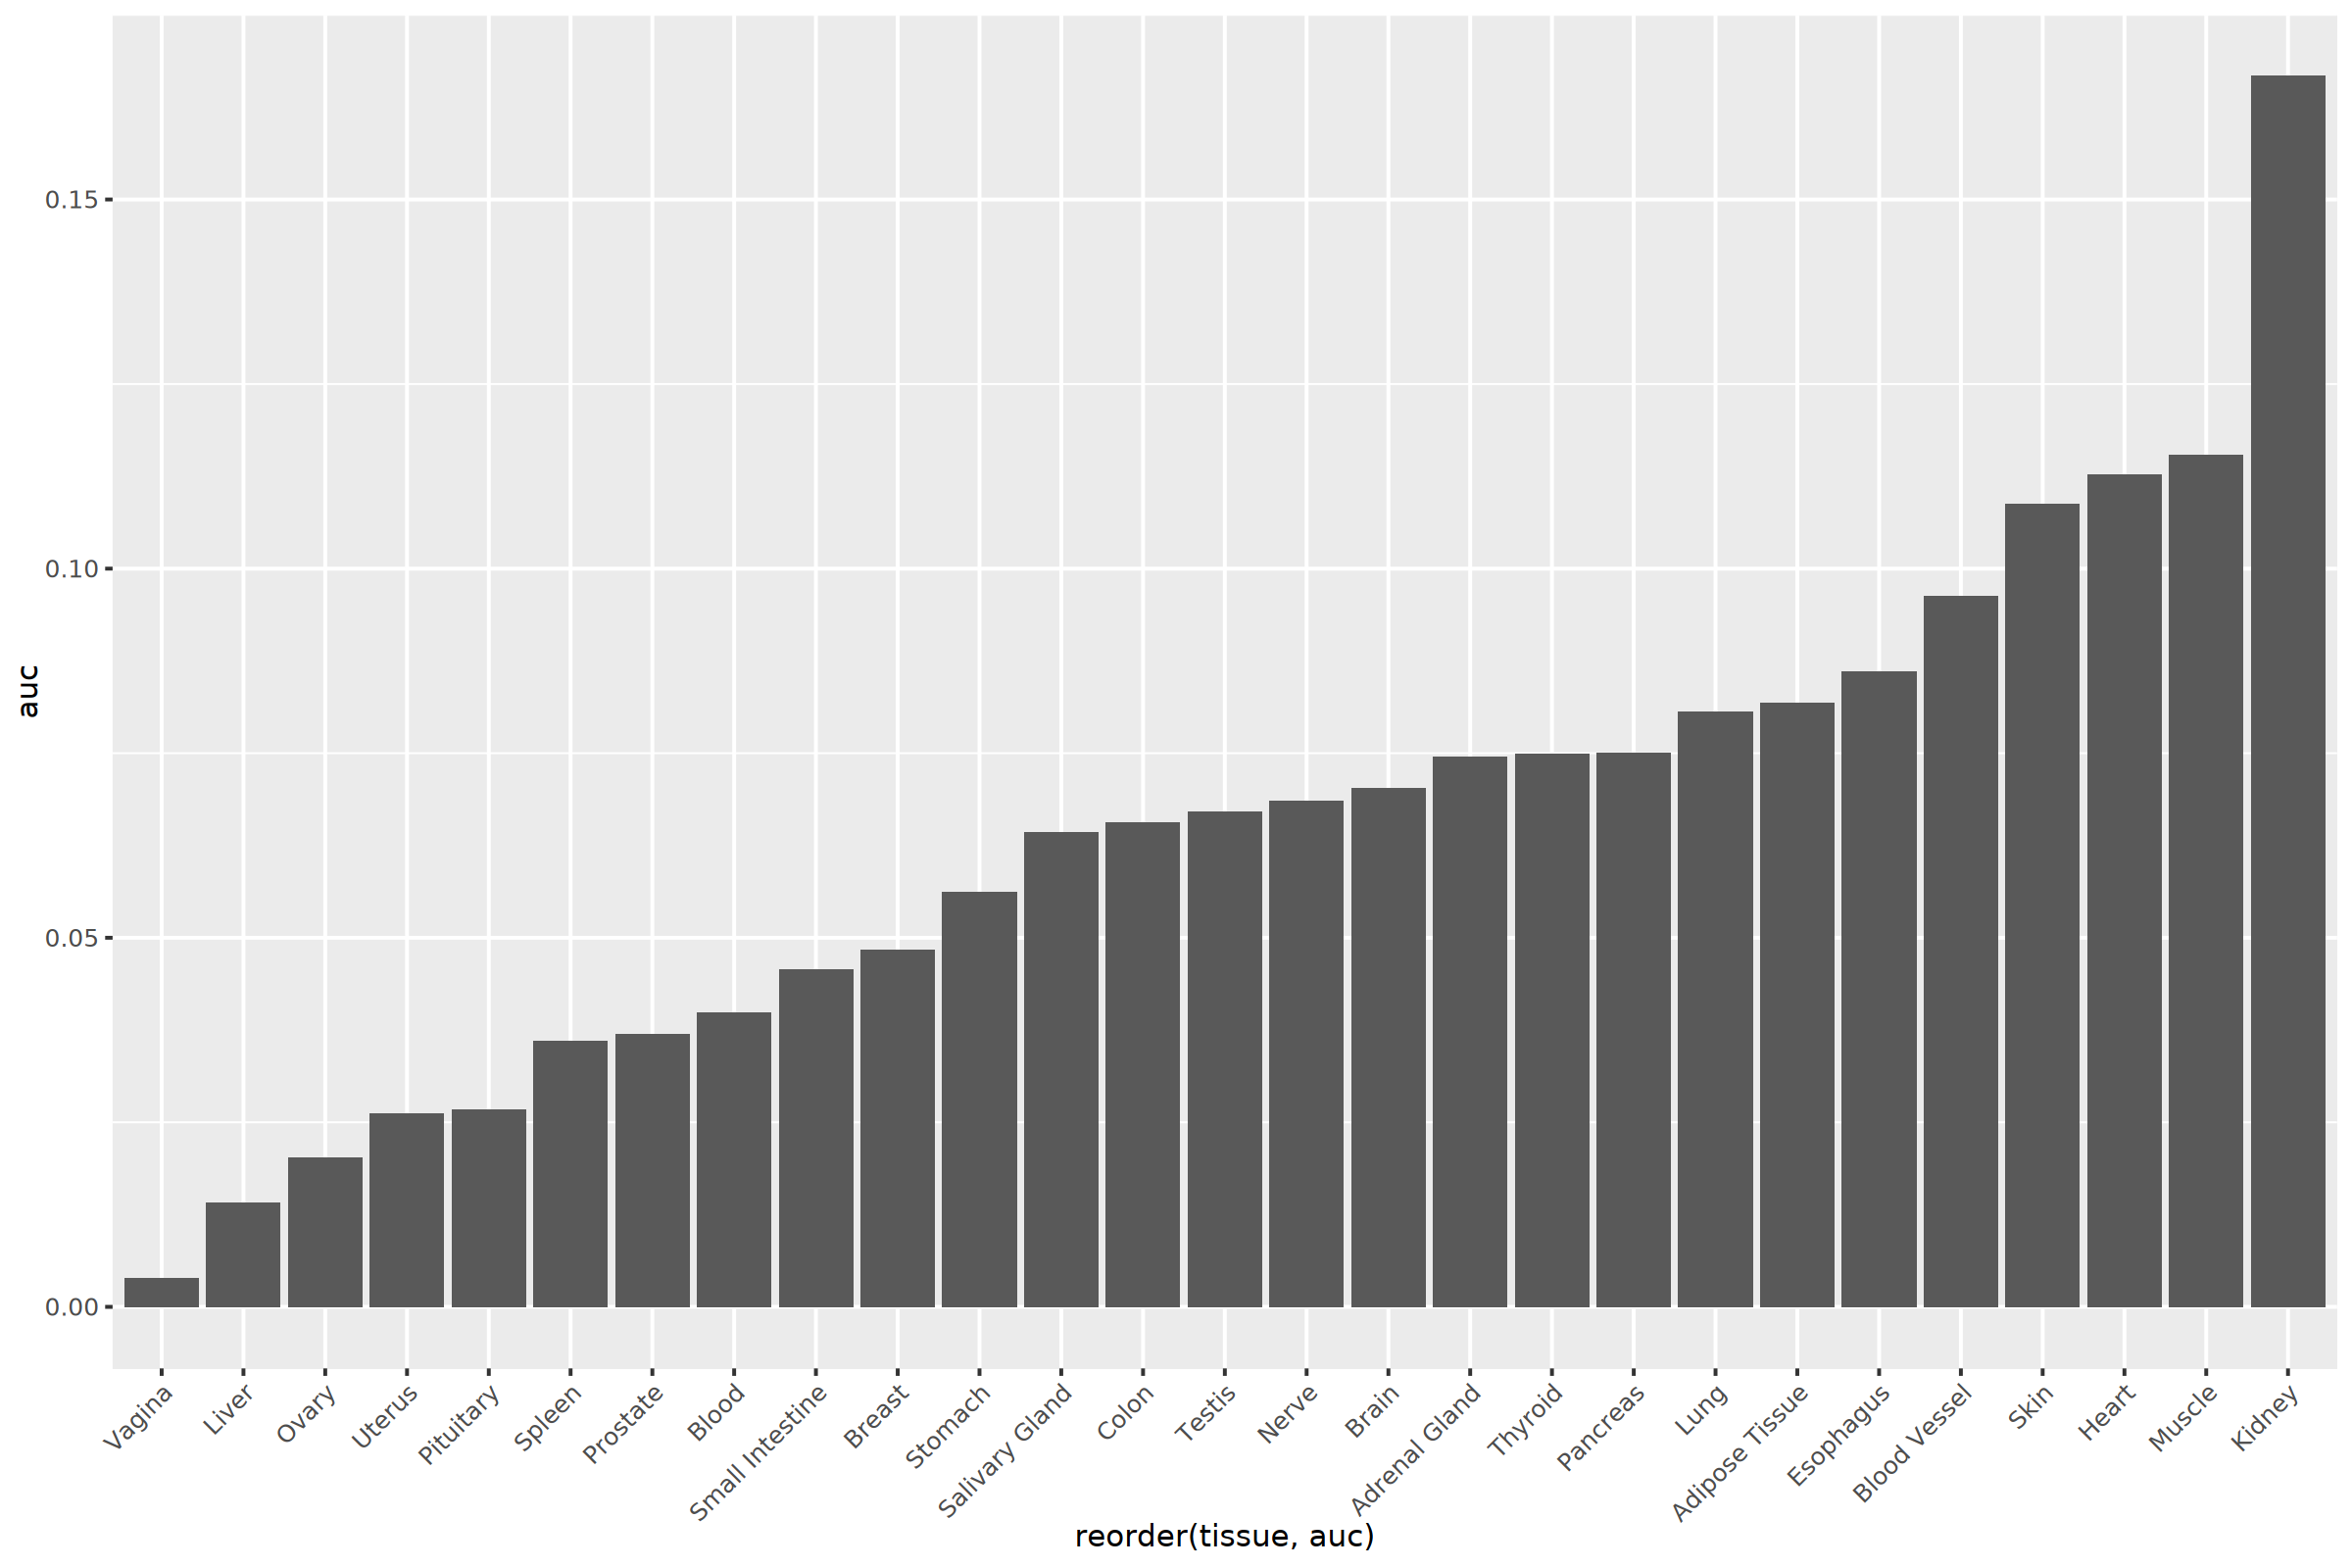

In [28]:
ggplot(tissue_performance[model=='+ SpeciesLM'], aes(x=reorder(tissue, auc), y=auc))  + geom_bar(stat = 'identity') + theme(
        axis.text.x=element_text(angle = 45, hjust = 1),) 

In [16]:
fold_performance = as.data.table(read_parquet(file.path(base_path, "/performance.folds.parquet")))
fold_performance = fold_performance[`model` %in% selected_models]
model_idx = unique(fold_performance[,.(`model`, `idx`)])[order(`idx`, decreasing = FALSE)]
fold_performance$model <- factor(fold_performance$model, levels=model_idx$model)
fold_performance$model <- recode(fold_performance$model, !!!rename_models)
fold_performance

model,fold,auc,idx,n_true,auc_mean,auc_median,auc_std
<fct>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
AbExp,0,0.09561466,0,1858,0.07183839,0.06834676,0.02095154
AbExp,1,0.06662600,0,1847,0.07183839,0.06834676,0.02095154
AbExp,2,0.04423836,0,1924,0.07183839,0.06834676,0.02095154
AbExp,3,0.09697845,0,1873,0.07183839,0.06834676,0.02095154
AbExp,4,0.07006751,0,1860,0.07183839,0.06834676,0.02095154
AbExp,test,0.05750536,0,1838,0.07183839,0.06834676,0.02095154
+ Enformer,0,0.09734583,3,1858,0.07214309,0.07144806,0.01911871
+ Enformer,1,0.06990317,3,1847,0.07214309,0.07144806,0.01911871
+ Enformer,2,0.04462806,3,1924,0.07214309,0.07144806,0.01911871


In [17]:
fold_performance[,.(num_folds=.N, median_auc=median(`auc`)), by="model"][order(`median_auc`)]

model,num_folds,median_auc
<fct>,<int>,<dbl>
AbExp,6,0.06834676
+ Enformer,6,0.07144806
+ Aparent2,6,0.07224591
+ SpeciesLM,6,0.07934412


In [18]:
tissue_performance[,.(num_tissues=.N, median_auc=median(`auc`)), by="model"][order(`median_auc`)]

model,num_tissues,median_auc
<fct>,<int>,<dbl>
+ Enformer,27,0.05704477
AbExp,27,0.05833111
+ Aparent2,27,0.06245021
+ SpeciesLM,27,0.06707545


In [19]:
auc_df = unique(prc_df[, .(`model`, `auc`, `idx`)])
auc_df[order(`auc`)]

model,auc,idx
<fct>,<dbl>,<int>
AbExp,0.06860093,0
+ Enformer,0.06990387,3
+ Aparent2,0.07253604,10
+ SpeciesLM,0.07639739,11


In [20]:
options(repr.plot.width=15, repr.plot.height=8)

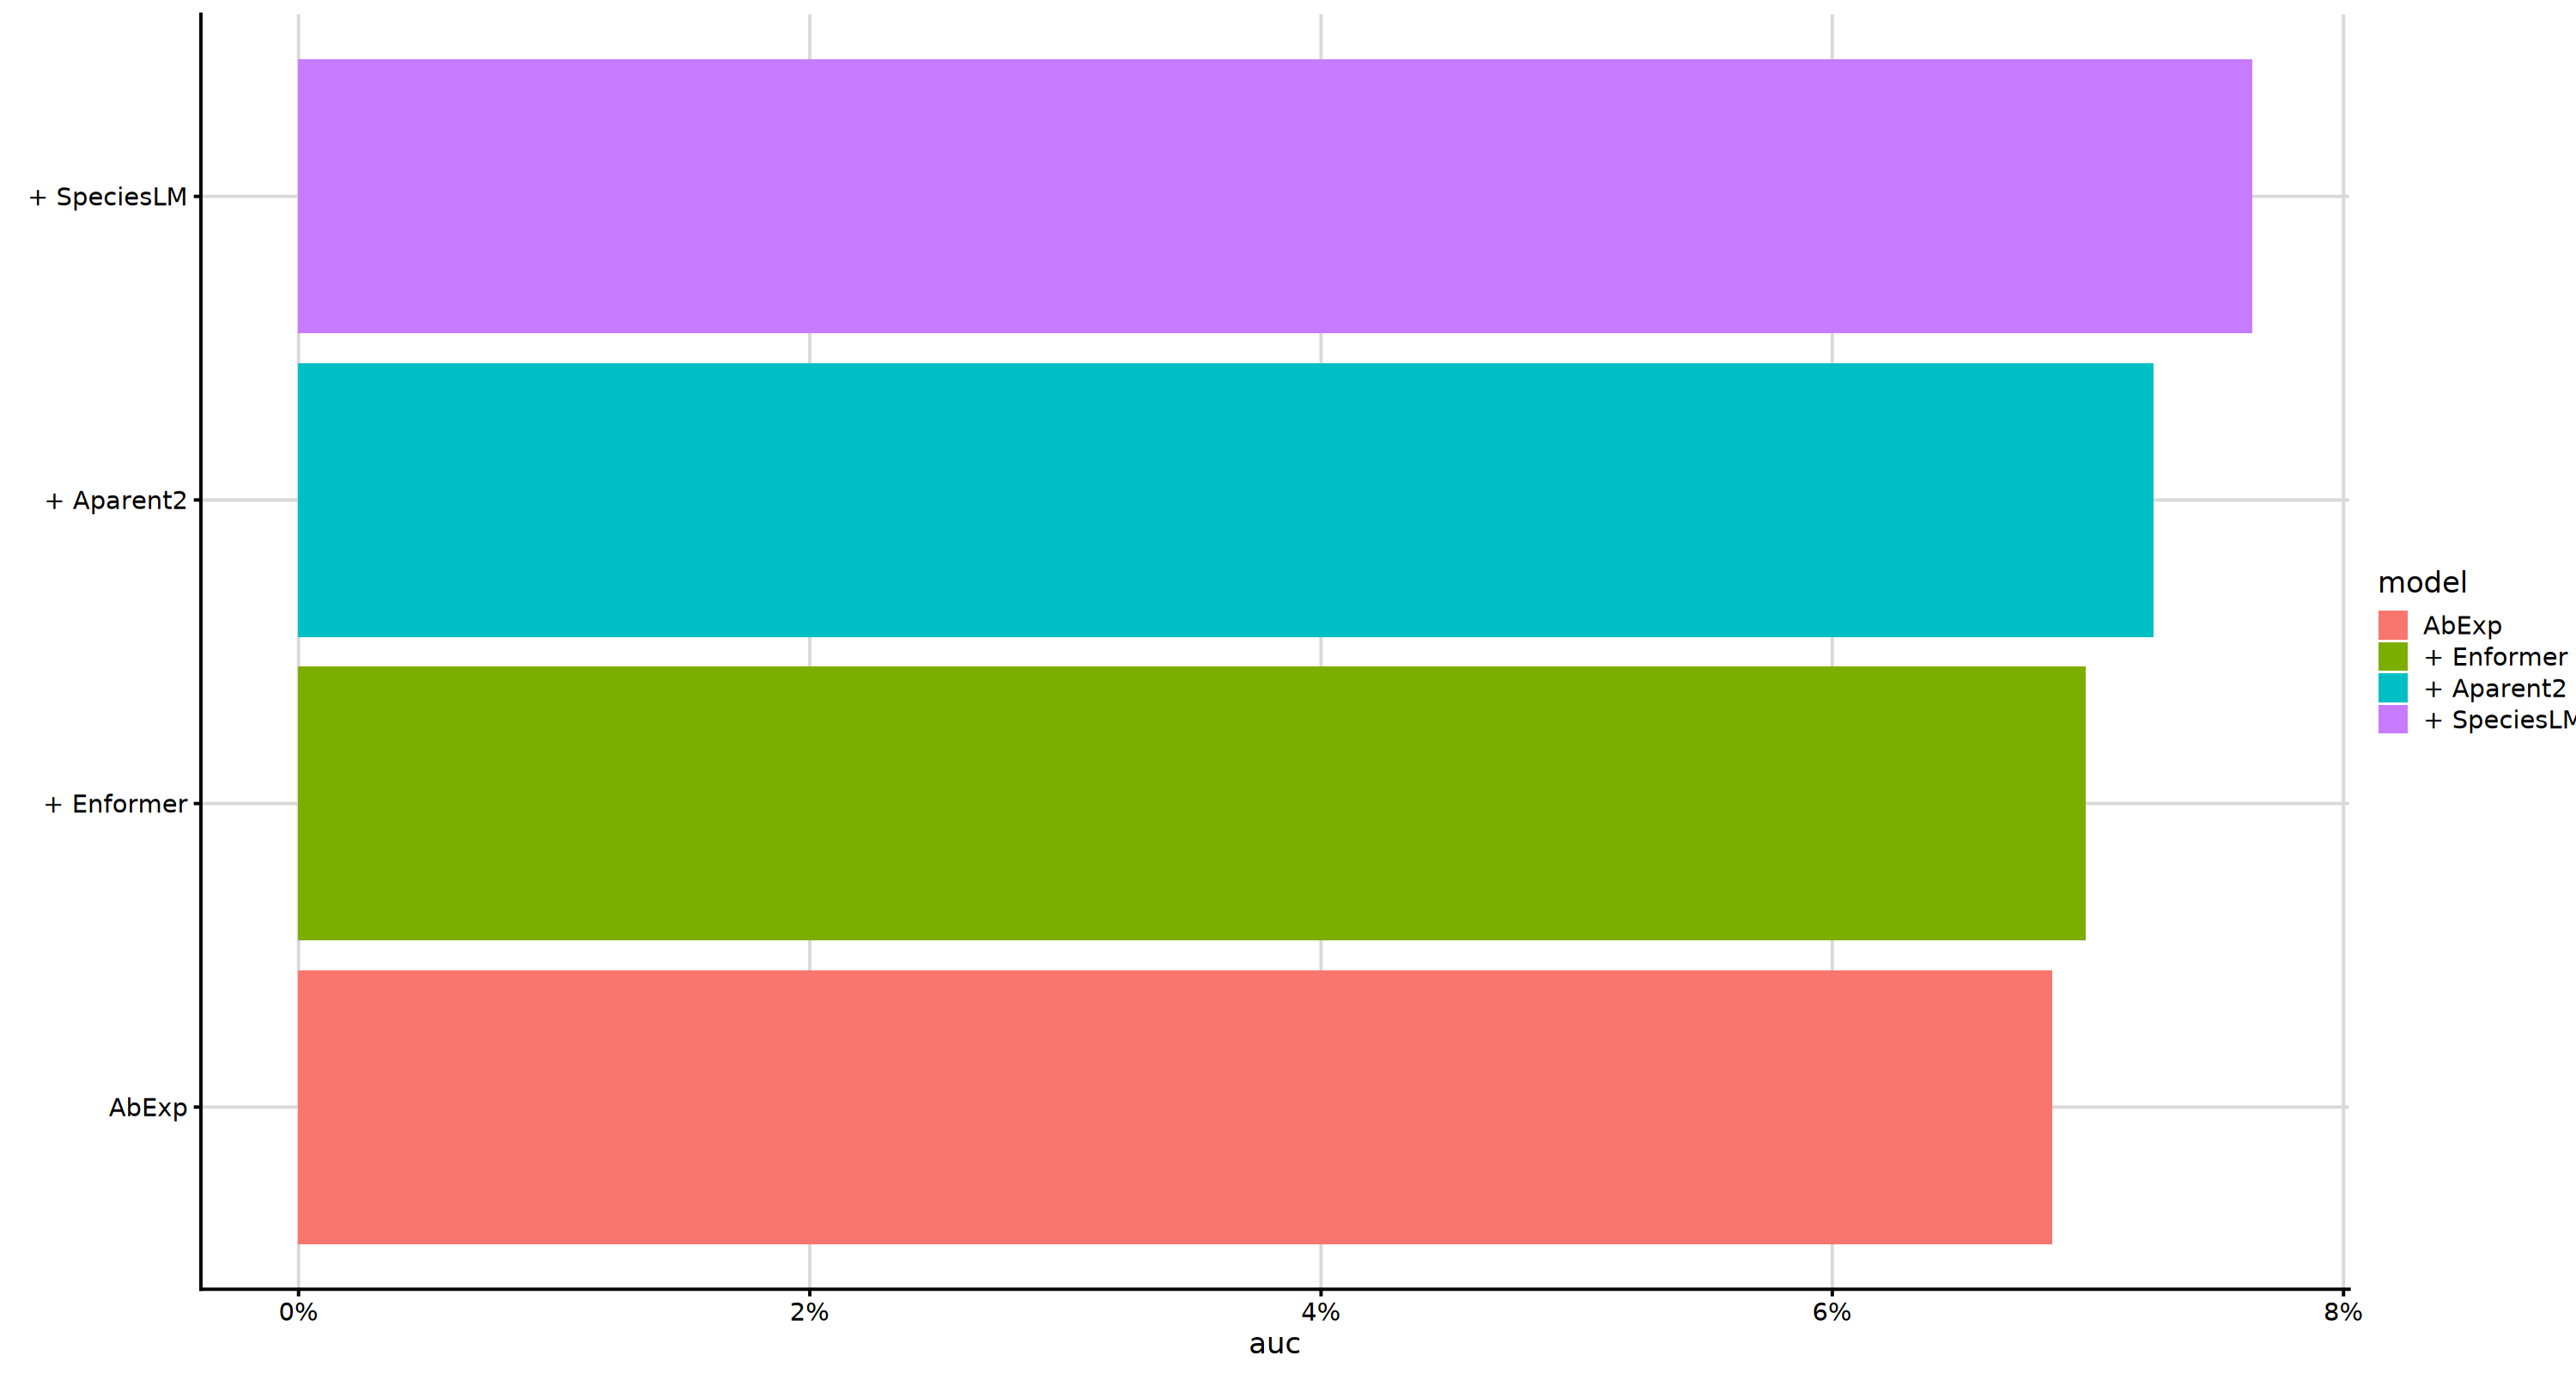

In [21]:
auc_bar_plot = (
    ggplot(auc_df, aes(x=reorder(`model`, `auc`), y=`auc`, fill=`model`))
    # + scale_fill_manual(name = element_blank(), values=renamed_colors)
    + geom_bar(stat="identity")
    + scale_y_continuous(labels = scales::percent)
    # + scale_x_discrete(labels = function(x) {
    #     x %>% str_replace_all(" \\+", "\n+") %>% str_replace_all(" \\(", "\n(")
    # })
    # + xlim(-0.05, 1.05)
    # + ylim(-0.05, 1.05)
    + xlab("")
    + THEME
    + background_grid()
    + coord_flip()
)
auc_bar_plot

In [22]:
# tissue_performance = tissue_performance %>% mutate(model = reorder(`model`, `auc`, FUN = median))

In [23]:
comparisons = list(
    c('AbExp', '+ Enformer'),
    c('+ Enformer', '+ Aparent2'),
    # c('AbExp', '+ Aparent2'),
    # c('AbExp\n+ Enformer\n+ Aparent2', 'AbExp\n+ SpeciesLM'),
    # c('AbExp\n+ SpeciesLM', 'AbExp\n+ Enformer\n+ Aparent2\n+ SpeciesLM'),
    c('+ Aparent2', '+ SpeciesLM')
)

In [24]:
stat.test <- (
    tissue_performance
    %>% wilcox_test(`auc` ~ `model`, paired=TRUE, comparisons = comparisons, alternative='less') 
    %>% add_significance("p")
)


# Add p-values to a boxplot
stat.test <- stat.test %>% add_xy_position(x = "model")
stat.test$all_lower = apply(stat.test, 1, function(x) all_lower(tissue_performance, "model", "auc", x$`group2`, x$`group1`) | all_lower(tissue_performance, "model", "auc", x$`group1`, x$`group2`))
stat.test$p_label = paste0(ifelse(stat.test$all_lower, "P < ", "P = "), lapply(stat.test$p, function(x) fancy_scientific(x, 3)))
as.data.table(stat.test)

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,p.signif,y.position,groups,xmin,xmax,all_lower,p_label
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<list>,<dbl>,<dbl>,<lgl>,<chr>
auc,AbExp,+ Enformer,27,27,145,1.51e-01,0.151000,ns,ns,0.17384,"AbExp , + Enformer",1,2,FALSE,P = 0.151
auc,+ Enformer,+ Aparent2,27,27,44,1.04e-04,0.000208,***,***,0.18410,"+ Enformer, + Aparent2",2,3,FALSE,P = 1.04x10⁻⁴
auc,+ Aparent2,+ SpeciesLM,27,27,39,5.49e-05,0.000165,***,****,0.19436,"+ Aparent2 , + SpeciesLM",3,4,FALSE,P = 5.49x10⁻⁵


In [25]:
stat.test$y.position = seq(from=0.14,by=0.02, length.out=length(comparisons))

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <b4>

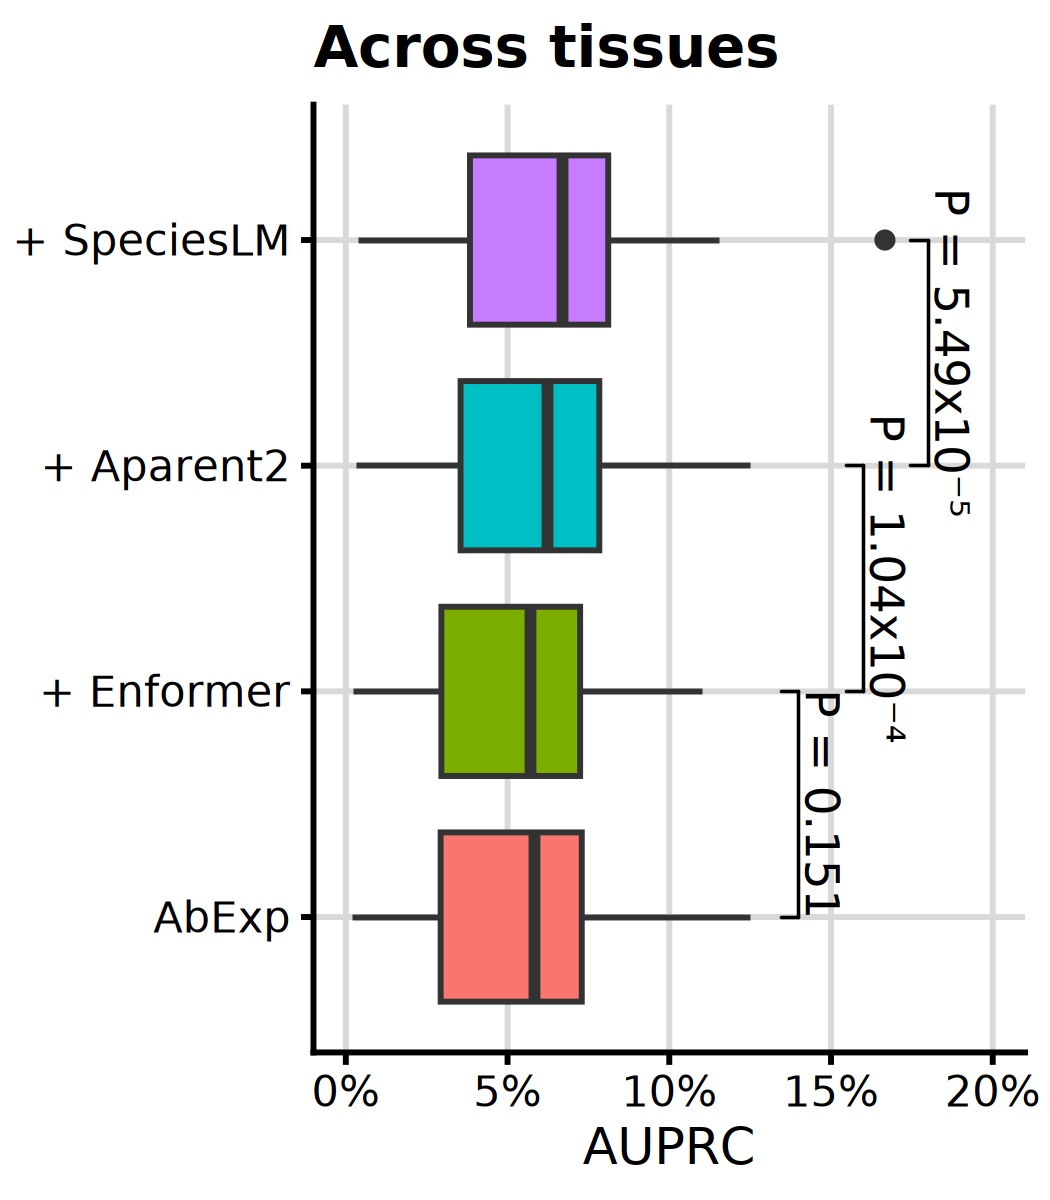

In [26]:
options(repr.plot.width=3.5, repr.plot.height=4, repr.plot.res=300)
auc_plot <- (
    ggplot(tissue_performance, aes(y=`auc`, x=`model`))
    # + scale_fill_manual(values=color_list)
    # + scale_fill_manual(name = element_blank(), values=renamed_colors)
    + geom_boxplot(aes(fill=`model`))
    + scale_y_continuous(
        limits=c(0, max(tissue_performance$auc) * 1.2),
        labels=scales::percent
    )
    # + scale_y_discrete(labels = function(x) {
    #     x %>% str_replace_all(" \\+", "\n+") %>% str_replace_all(" \\(", "\n(")
    # })
    # + geom_jitter(alpha=0.5)
    + THEME
    + background_grid(major = "xy")
    # + theme(legend.title = element_blank(), axis.title.y=element_blank())
    + theme(legend.title = element_blank())
    + theme(legend.position = "none")
    + coord_flip()
    + labs(
        y="AUPRC",
        x=element_blank(),
        title="Across tissues"
    )
    + stat_pvalue_manual(stat.test, label = "{p_label}", coord.flip=TRUE)
    # + stat_compare_means(
    #     comparisons = list(
    #         c(rename_models[["LOFTEE+CADD+consequences"]], "LOFTEE"),
    #         c(rename_models[["LOFTEE+CADD+consequences"]], "CADD")
    #         # c(rename_models[["LOFTEE+CADD+weighted VEP"]], rename_models[["LOFTEE+CADD+VEP"]])
    #         # c(rename_models[["LOFTEE+CADD+weighted VEP+dispersion"]], rename_models[["LOFTEE+CADD+weighted VEP"]])
    #         # c("AbExp-DNA:\nvariant effects + tissue-specificity + AbSplice + SV", "variant effects + tissue-specificity + AbSplice")
    #     ),
    #     method = "wilcox.test",
    #     paired=TRUE,
    # )
)
auc_plot

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


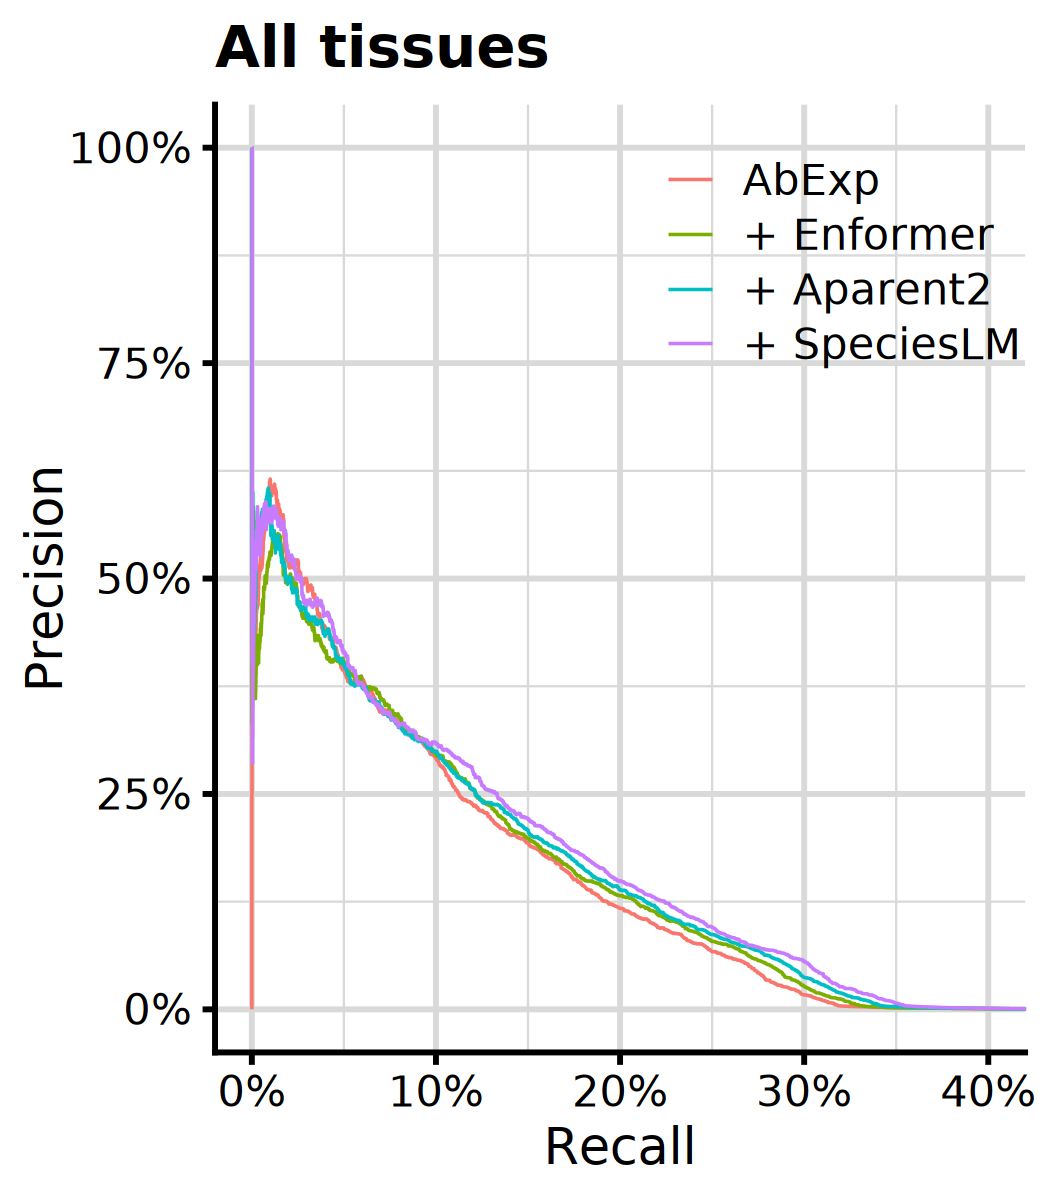

In [27]:
options(repr.plot.width=3.5, repr.plot.height=4, repr.plot.res=300)
prc_plot = (
    ggplot(prc_df, aes(x=`recall`, y=`precision`))
    + geom_step(aes(color=reorder(`model`, `idx`)), linewidth=LINESIZE, direction="vh")
    # + scale_color_manual(name = element_blank(), values=nonbinary_model_colors)
    # + new_scale("color")
    + THEME
    + background_grid(major = "xy", minor = "xy")
    + scale_x_continuous(
        limits = c(0, 1),
        # breaks = seq(0, 1, 0.2),
        # minor_breaks = seq(0, 1, 0.2)
        labels=scales::percent
    )
    + scale_y_continuous(
        limits = c(0, 1),
        # breaks = seq(0, 1, 0.2),
        # minor_breaks = seq(0, 1, 0.2)
        labels=scales::percent
    )
    + coord_cartesian(xlim=c(0, 0.4), ylim = c(0, 1))
    + scale_shape_manual(name=element_blank(), values=c(4, 4))
    + guides(color=guide_legend(order = 1), shape=guide_legend(order = 2))
    + theme(
        #legend.position="right",
        legend.title=element_blank(),
        legend.position = c(0.95, 0.95),
        legend.justification = c("right", "top"),
        # axis.text.x=element_text(angle=45, hjust=1),
    )
    + labs(
        x='Recall',
        y='Precision',
        title="All tissues"
    )
)
prc_plot

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 1.04x10⁻⁴' in 'mbcsToSbcs': dot substituted for <b4>

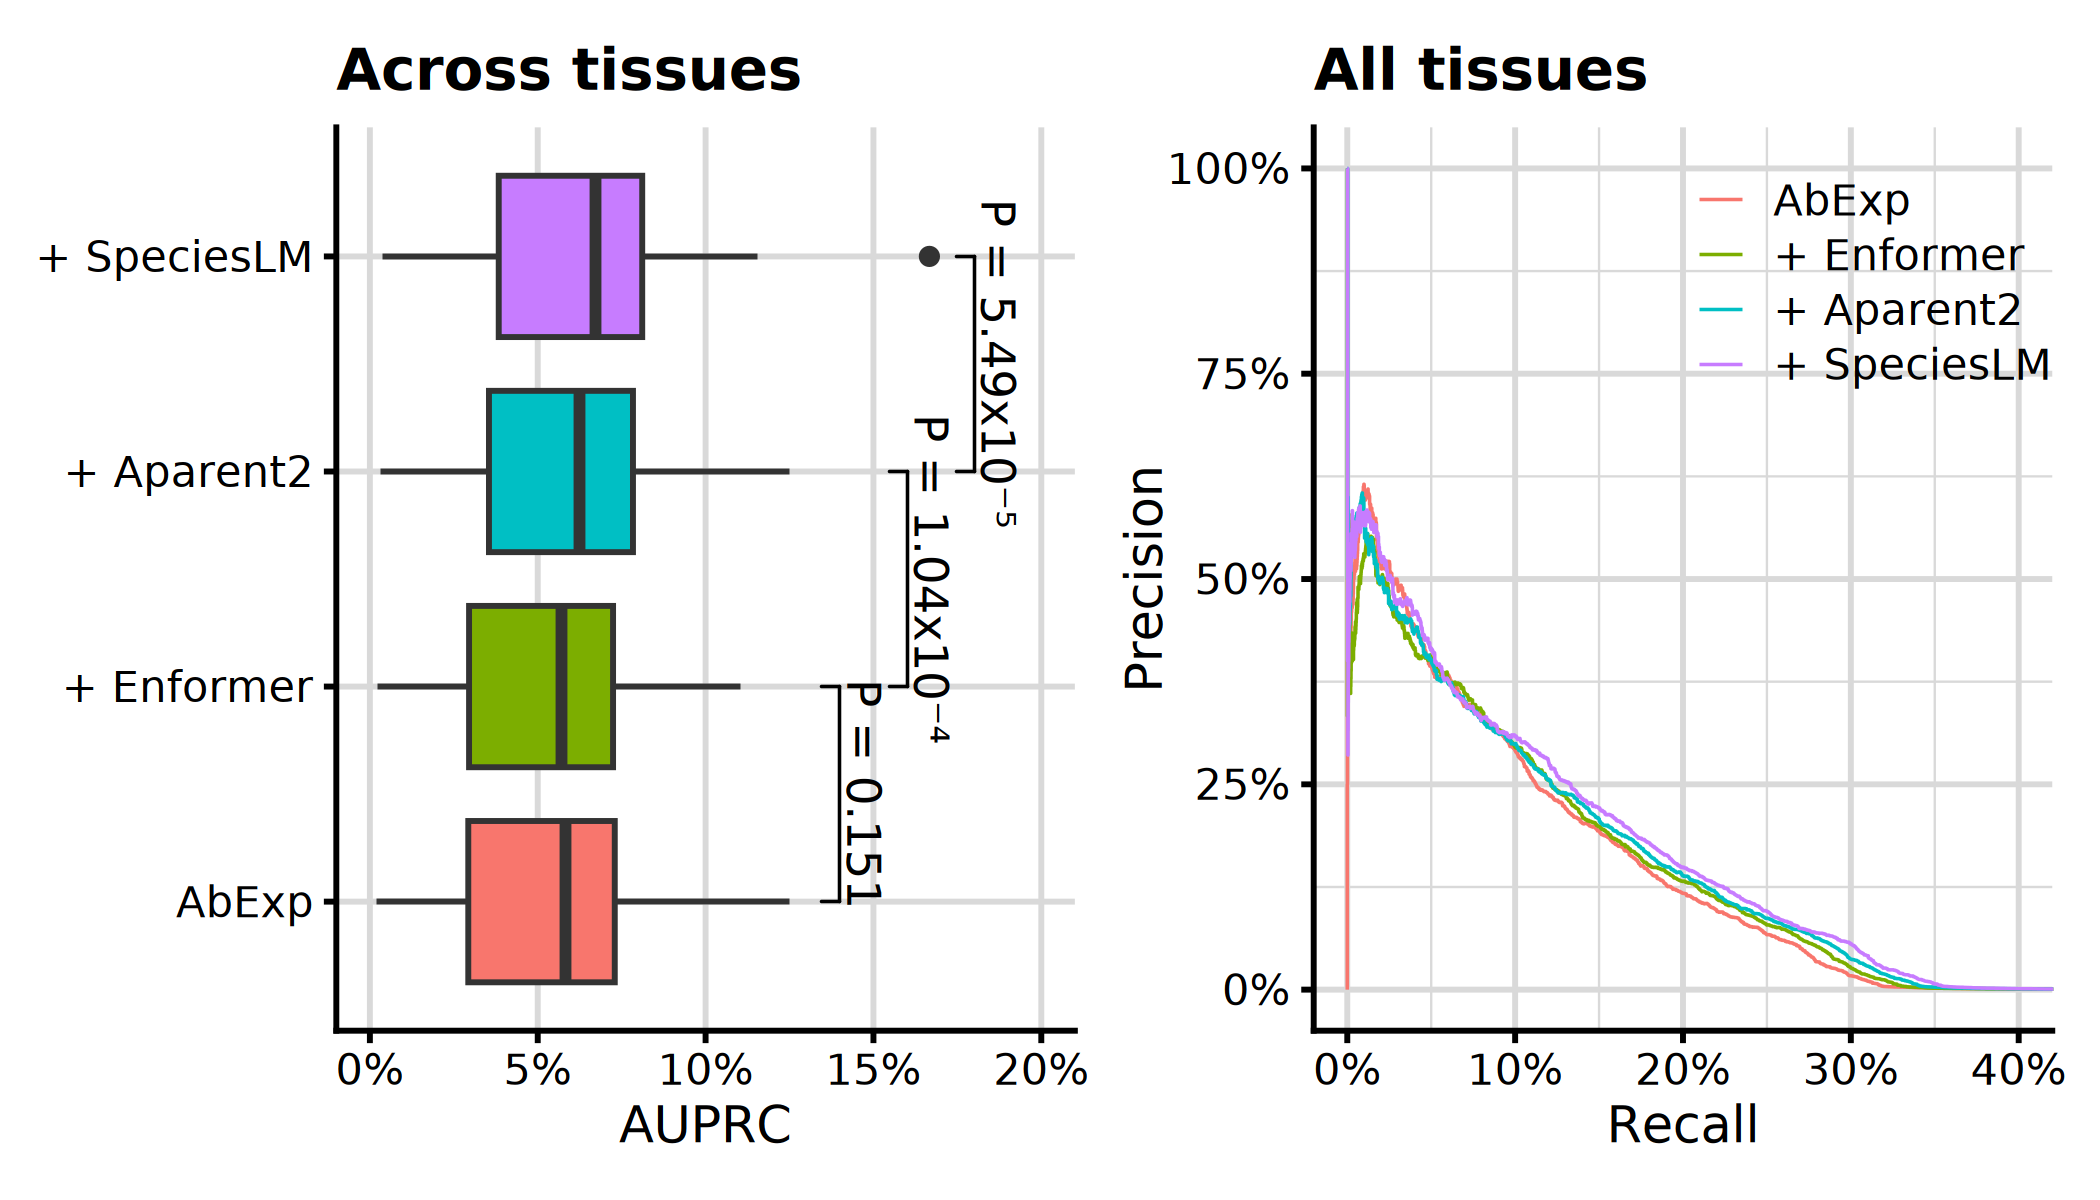

In [28]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=300)
p = auc_plot + prc_plot
p

In [29]:
width=7
height=4

path = paste(output_path, 'complex_prc_auc_under', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), p, width = width, height = height, dpi=600, type='cairo')

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/complex_prc_auc_under..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”
